# 1. Introduction

## 1.1. Présentation du projet et explication de la démarche


## 1.2. Chargement des packages

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point
from pynsee.geodata import get_geodata_list, get_geodata, GeoFrDataFrame

from outils import *

from matplotlib import pyplot as plt
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
from io import BytesIO


## 1.3. Chargement des données

### 1.3.1. Données INSEE
On commence par charger la base de données 'données locales' qui contient entre autre
* Le nom des communes française
* Leur population au dernier recensement
* Leur coordonnées géographiques des communes
On s'aide pour cela de la documentation de pynsee (les commandes ici sont utilisable sans clé API)

In [3]:
# On récupère la liste géographique
geodata_list = get_geodata_list()
# On récupère la liste des limites géographique des départements
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

mapcom_raw = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

#Le jeu de données contenant les informations que nous cherchons est le suivant
mapcom_raw.sample(5)

100%|██████████| 99/99 [00:52<00:00,  1.87it/s]


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
23582,COMMUNE_0000000009752555,Montrond-les-Bains,MONTROND-LES-BAINS,42149,Commune simple,5550,01,1,42,84,200065894,"MULTIPOLYGON (((469502.031 5724614.368, 469589...",EPSG:3857
6752,COMMUNE_0000000009757338,Dausse,DAUSSE,47079,Commune simple,531,16,3,47,75,200068930,"MULTIPOLYGON (((100864.296 5526749.01, 101057....",EPSG:3857
22438,COMMUNE_0000000009729362,Lemé,LEME,02416,Commune simple,415,11,5,02,32,240200444,"MULTIPOLYGON (((422111.537 6419677.015, 422119...",EPSG:3857
23155,COMMUNE_0000000009759188,Saint-Étienne-du-Grès,SAINT-ETIENNE-DU-GRES,13094,Commune simple,2486,26,2,13,93,241300375,"MULTIPOLYGON (((530374.718 5434330.342, 530361...",EPSG:3857
17526,COMMUNE_0000000009731023,Mareuil-la-Motte,MAREUIL-LA-MOTTE,60379,Commune simple,608,21,3,60,32,246000855,"MULTIPOLYGON (((314310.672 6369461.447, 314558...",EPSG:3857


In [199]:
# Surtout dans les DROM-COM certaines communes apparaissent aussi comme sous-préféctures,par exemple:
mapcom_raw[(mapcom_raw['nom_m'] == 'SAINT-CLAUDE')]


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
6,COMMUNE_0000001169858685,Saint-Claude,SAINT-CLAUDE,97124,Commune simple,10700,06,1,971,01,249710070,"MULTIPOLYGON (((-6869802.488 1804329.757, -687...",EPSG:3857
27957,COMMUNE_0000000009749074,Saint-Claude,SAINT-CLAUDE,39478,Sous-préfecture,8727,14,3,39,27,200026573,"MULTIPOLYGON (((648695.631 5837666.044, 648666...",EPSG:3857


In [4]:
# Ainsi, certaines communes apparaisent en double en tant que sous-préféctures, on ne garde ici que les communes

# On identifie les doublons dans la colonne 'nom_m'
duplicates = mapcom_raw[mapcom_raw['nom_m'].duplicated(keep=False)]

# On sélectionne les lignes où 'statut' est égal à 'Commune simple'
simple_communes = duplicates[duplicates['statut'] == 'Commune simple']

# On conserve les lignes avec des 'nom_m' uniques ou celles avec 'Commune simple' lorsque des doublons existent
mapcom = pd.concat([
    mapcom_raw[~mapcom_raw['nom_m'].duplicated(keep=False)],  # Lignes sans doublons
    simple_communes  # Lignes où 'Commune simple' est sélectionné
]).drop_duplicates(subset='nom_m', keep='first')  # S'assurer que 'nom_m' est unique dans le résultat final

# Réinitialiser l'index pour plus de clarté 
mapcom.reset_index(drop=True, inplace=True)

# Afficher le DataFrame final
mapcom.sample(5)


,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
5682,COMMUNE_0000000009762015,Bernac-Debat,BERNAC-DEBAT,65083,Commune simple,730,07,3,65,76,200069300,"MULTIPOLYGON (((10137.24 5337875.534, 10168.00...",EPSG:3857
8485,COMMUNE_0000000009730786,Les Trois-Pierres,LES TROIS-PIERRES,76714,Commune simple,797,32,2,76,28,200084952,"MULTIPOLYGON (((47702.803 6371146.282, 47538.1...",EPSG:3857
30430,COMMUNE_0000000009736322,Arzviller,ARZVILLER,57033,Commune simple,531,17,5,57,44,245700950,"MULTIPOLYGON (((798709.52 6229950.704, 798743....",EPSG:3857
8344,COMMUNE_0000000009734097,Saint-Martin-du-Tilleul,SAINT-MARTIN-DU-TILLEUL,27569,Commune simple,245,02,2,27,28,200066413,"MULTIPOLYGON (((59566.11 6290684.285, 59283.78...",EPSG:3857
1108,COMMUNE_0000000009762274,Estérençuby,ESTERENCUBY,64218,Commune simple,313,12,1,64,75,200067106,"MULTIPOLYGON (((-134339.743 5330241.287, -1342...",EPSG:3857


### 1.3.2. Données Géod'air

Les données Géod'air sont un jeu de données issue de Géod'air le pourvoyeur public de données sur la pollution atmosphériques. Elles consistent en des jeux de données .csv tékéchargées préalablements représentant la mesure de 5 polluants différents et des informations conjointes (nom et lieux des sites de meusures, types de mesures, etc.) regroupés par intervalles de 6 mois entre le 1er janvier 2020 et le 31 décembre 2023.
On compte donc au total 40 fichiers .csv.

**Remarque :** Pour obtenir les données une API existe, cependant celle ci ne permet que d'obtenir des données par intervals de 1 jour, afin de gagner du temps dans les requêtes et pour ne pas risquer de surcharger les serveurs de Géod'air nous avons préféré utiliser leur outil de chargement sur-mesure des données

In [5]:
folder_paths = [
   r"CSV_data\GEODAIR\NO2\NO2_moy_hor_per", #Utiliser soit r"..." soit des \\ sinon les "\N" de "\NO2" posent problème
    "CSV_data\GEODAIR\O3\O3_moy_hor_per",
    "CSV_data\GEODAIR\PM2.5\PM2.5_moy_jour_per",
    "CSV_data\GEODAIR\PM10\PM10_moy_jour_per",
    "CSV_data\GEODAIR\SO2\SO2_moy_hor_per"
    ]

#Ici l'instruction "range(8,1,-1)" permet de classer les chemins du plus récent au moins récent.
all_file_paths = [[ folder + str(i) + ".csv" for i in range(8,0,-1)] for folder in folder_paths]

# On combine les 40 (5x8) jeux de données en 5 dataframes allant de janvier 2020 à décembre 2023
# Pour les polluants dans l'ordre suivant: NO2, O3, PM2.5, PM10, SO2
all_combined_df = [pd.concat([pd.read_csv(file, sep = ";") for file in all_file_paths[i]]) for i in range(5)]

#On obtien une liste de 5 dataframes, soit un par polluant

In [8]:
# On souhaite avoir un jeu de données pour lesquels seuls les mesures ayant mesuré tous les polluants sont conservés
# On précise les colonnes sur lesquels on applique la jonction
join_columns = ["Date de début", "Date de fin", "code site"]

# On sélectionne le data frame avec le plus petit nombre de lignes
smallest_df = min(all_combined_df, key=len)

# On initialise avec les plus petit data frame
result_df = smallest_df

# On joint chaque dataframe de notre liste "all_combined_df" avec un suffixe unique
for i, df in enumerate(all_combined_df):
    if df is not smallest_df:  # pour éviter l'auto-jonction
        result_df = pd.merge(
            result_df, 
            df, 
            on=join_columns, 
            how='inner', 
            suffixes=(None, f'_df{i}')  # Un suffixe unique pour chaque data frame
        )

# result_df contient maintenant le inner join of de tous les data frames sur les colonnes spécifées
# On obtient un objet qui contient beaucoup plus de variable que ce qui nous intéresse, on vien donc procéder à un premier tri

# Soit la liste des variables les plus utiles, on peut l'utiliser pour extraire un version synthétique du de result_df
best_variables = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',
    'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',
    'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',
    'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',
    'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',
    'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',
]

best_df = result_df[best_variables]

# Etape cosmétique pour faciliter la lecture des données intermédiaires
# On définit une fonction pour renommer les colonnes
# Définir les colonnes qui doivent garder leur nom tel quel
columns_to_keep = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 
    'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude'
]

# Définir la fonction pour renommer les colonnes
def rename_columns(column_name):
    # Vérifier si la colonne doit conserver son nom
    if column_name in columns_to_keep:
        return column_name
    # Ajouter le suffixe "_SO2" pour les colonnes sans suffixe qui ne sont pas dans columns_to_keep
    elif not any(column_name.endswith(suffixe) for suffixe in ["_df0", "_df1", "_df2", "_df3"]):
        return f"{column_name}_SO2"
    # Remplacer les suffixes spécifiques
    elif column_name.endswith("_df0"):
        return column_name.replace("_df0", "_NO2")
    elif column_name.endswith("_df1"):
        return column_name.replace("_df1", "_O3")
    elif column_name.endswith("_df2"):
        return column_name.replace("_df2", "_PM2.5")
    elif column_name.endswith("_df3"):
        return column_name.replace("_df3", "_PM10")
    else:
        return column_name

best_df = best_df.rename(columns=rename_columns)


# Pour l'instant les données ne sont pas dans un format géographique, on transforme donc le dataframe en GeoDataFrame
best_dfgeo = gpd.GeoDataFrame(
    best_df, geometry=gpd.points_from_xy(best_df.Longitude, best_df.Latitude)
)

# Une visualisation des données donne donc:
best_dfgeo.sample(5)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,code qualité_PM2.5,validité_PM2.5,Polluant_PM10,type de valeur_PM10,valeur_PM10,valeur brute_PM10,unité de mesure_PM10,code qualité_PM10,validité_PM10,geometry
12870,2021/11/27 00:00:00,2021/11/27 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,A,1,PM10,Moy. journalière,13.0,12.641667,µg-m3,A,1,POINT (0.10064 49.51469)
13307,2021/12/27 00:00:00,2021/12/27 23:59:59,ATMO GRAND EST,FR44ZRE01,ZR GRAND-EST,FR30033,Jonville en Woevre,Rurale régionale,49.065830,5.785556,...,A,1,PM10,Moy. journalière,9.0,9.445833,µg-m3,A,1,POINT (5.78556 49.06583)
4602,2023/05/08 00:00:00,2023/05/08 23:59:59,ATMO HAUTS DE FRANCE,FR32ZRE01,ZR HAUTS-DE-FRANCE,FR18042,P. Roth St Quentin,Urbaine,49.851334,3.284000,...,A,1,PM10,Moy. journalière,9.0,9.308333,µg-m3,A,1,POINT (3.284 49.85133)
5628,2022/07/10 00:00:00,2022/07/10 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38020,Plateau Caillou,Urbaine,-21.022112,55.266773,...,A,1,PM10,Moy. journalière,10.0,10.075000,µg-m3,A,1,POINT (55.26677 -21.02211)
8543,2022/02/01 00:00:00,2022/02/01 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38020,Plateau Caillou,Urbaine,-21.022112,55.266773,...,N,-1,PM10,Moy. journalière,19.0,18.712500,µg-m3,N,-1,POINT (55.26677 -21.02211)


In [6]:
#On revient maintenant à notre liste de dataframe, afin de pouvoir identifier les communes au sein desquelles les mesures ont été faites
#Pour rappel, on a tous les df dans la liste all_combined_df
result = []
result_simple = []
result_simple_agg = []
geometries = []
variable_gdf = []

# On séléctionne les variables les plus intéréssantes pour le projet 
variable_interet = ['Date de fin',
                    "type d'implantation",
                    "type d'influence", 
                    'valeur', 
                    'geometry',
                    'index_right', 
                    'id', 
                    'nom', 
                    'nom_m', 
                    'insee_com', 
                    'statut',
                    'population', 
                    'insee_can', 
                    'insee_arr', 
                    'insee_dep', 
                    'insee_reg',
                    'siren_epci', 
                    'crsCoord'
                    ]

for indice_polluant in range(5):
    gdf = gpd.GeoDataFrame(all_combined_df[indice_polluant], geometry=gpd.points_from_xy(all_combined_df[indice_polluant].Longitude, all_combined_df[indice_polluant].Latitude)).set_crs('EPSG:4326') #EPSG:4326 est le CRS correspondant aux longitudes-latitudes
    #On projette mapcom les données dans le même CRS
    mapcom = mapcom.to_crs(gdf.crs) 
    #Jonction spatiale, l'argument within identifie les coordonnées qui sont au sein des géométries des communes
    result.append(gpd.sjoin(gdf, mapcom, how="left", predicate="within"))
    # Cette étape permet de formater les dates au format datetime
    result[indice_polluant]['Date de fin'] = result[indice_polluant]['Date de fin'].apply(format_date)

    result_simple.append(result[indice_polluant][variable_interet])

    #On va maintenant grouper les mesures par commune et par jour pour alléger le jeu de données
    result_simple_agg.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'], as_index=False).agg({'valeur': 'mean'}))
    
    # On ajoute ici une géométrie en reprenant la première géométrie de chaque groupe
    geometries.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'])['geometry'].first().reset_index())
    
    # On fusionne pour réassocier la géométrie
    variable_gdf.append(gpd.GeoDataFrame(result_simple_agg[indice_polluant].merge(geometries[indice_polluant],on=['nom_m', 'Date de fin']),geometry='geometry', crs=result_simple[indice_polluant].crs))
    
    # On renomme 'Date de fin' en un plus simple 'date'
    variable_gdf[indice_polluant].rename(columns = {'Date de fin' : 'date'}, inplace = True)

# On obtient pour chaque polluant un GéoDataFrame ayant les données suivantes: 
# nom de la commune en majuscule ('nom_m')
# date au format datetime ('date')
# La valeur moyenne des mesures de pulluants ce jour là et à cette date là ('valeur')
# Les coordonnées sous forme d'un objet POINT ('geometry')
variable_gdf[4].sample(5)

#Remarque : cette cellule peut prendre du temps à s'effectuer

,nom_m,date,valeur,geometry
1206,AIRVAULT,2023-04-30,0.3,POINT (-0.13563 46.8238)
85888,SAINTE-ADRESSE,2022-09-01,7.0,POINT (0.08461 49.50386)
89820,TANCARVILLE,2021-08-24,0.5,POINT (0.45176 49.48768)
78206,SAINT-GAUDENS,2021-06-25,4.0,POINT (0.71955 43.10616)
40889,LACQ,2022-05-17,2.7,POINT (-0.61773 43.41123)


In [7]:
# Enfin, on vient fusionner les 5 dataframe en un (outer join car on veut conserver le plus d'information possible)
all_variable_gdf1 = pd.merge(variable_gdf[0],variable_gdf[1], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_NO2','_O3'))
all_variable_gdf2 = pd.merge(variable_gdf[2],variable_gdf[3], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_PM2.5','_PM10'))
all_variable_gdf2 = pd.merge(all_variable_gdf2,variable_gdf[4], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,'_SO2'))
all_variable_gdf = pd.merge(all_variable_gdf1,all_variable_gdf2, how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,False))
mapcom_simple = mapcom[['id', 'nom_m', 'insee_com', 'statut', 'population', 'insee_dep']]
all_variable_gdf = pd.merge(all_variable_gdf, mapcom_simple, how = 'left', on = 'nom_m', validate = 'm:1',suffixes = (False,False))


#Etape cosmétique pour faciliter la lisibilité (on fait apparaître le nom de chaque polluant)
all_variable_gdf.rename(columns = {
    'valeur_NO2': 'NO2',
    'valeur_O3': 'O3',
    'valeur_PM2.5': 'PM2.5',
    'valeur_PM10':'PM10',
    'valeur' : 'SO2'}, inplace = True)


In [8]:
# On vient éliminer certains duplicatats issus d'irrégularités au sein de la variable geometry
grouping_columns = all_variable_gdf.drop(columns=['NO2', 'O3', 'PM2.5', 'PM10', 'SO2','geometry']).columns
#On enlève la colonne geometry car celle ci comporte des doublons à un 100 000ième de coordonnée près
polluants_gdf = all_variable_gdf.groupby(list(grouping_columns), as_index=False).agg({
    'NO2': 'max',
    'O3': 'max',
    'PM2.5': 'max',
    'PM10': 'max',
    'SO2': 'max'
})

#On rajoute la colonne geometry en ne conservant qu'une seulle valeur pour chaque ville
geometries = all_variable_gdf[['nom_m','geometry']].drop_duplicates(subset='nom_m')

polluants_gdf = gpd.GeoDataFrame(pd.merge(polluants_gdf,geometries, how = 'left', on= 'nom_m'),geometry='geometry', crs='EPSG:4326')

In [11]:
polluants_gdf

,nom_m,date,id,insee_com,statut,population,insee_dep,NO2,O3,PM2.5,PM10,SO2,geometry
0,AGDE,2020-01-01,COMMUNE_0000000009761167,34003,Commune simple,29103,34,23.2,53.4,NaN,NaN,NaN,POINT (3.50484 43.2875)
1,AGDE,2020-01-02,COMMUNE_0000000009761167,34003,Commune simple,29103,34,32.8,33.9,NaN,NaN,NaN,POINT (3.50484 43.2875)
2,AGDE,2020-01-03,COMMUNE_0000000009761167,34003,Commune simple,29103,34,24.6,55.1,NaN,NaN,NaN,POINT (3.50484 43.2875)
3,AGDE,2020-01-04,COMMUNE_0000000009761167,34003,Commune simple,29103,34,11.4,67.2,NaN,NaN,NaN,POINT (3.50484 43.2875)
4,AGDE,2020-01-05,COMMUNE_0000000009761167,34003,Commune simple,29103,34,26.7,67.8,NaN,NaN,NaN,POINT (3.50484 43.2875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
560652,XONRUPT-LONGEMER,2023-12-27,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.7,77.8,NaN,NaN,NaN,POINT (7.01111 48.05112)
560653,XONRUPT-LONGEMER,2023-12-28,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.7,73.2,NaN,NaN,NaN,POINT (7.01111 48.05112)
560654,XONRUPT-LONGEMER,2023-12-29,COMMUNE_0000000009741120,88531,Commune simple,1488,88,1.4,71.8,NaN,NaN,NaN,POINT (7.01111 48.05112)
560655,XONRUPT-LONGEMER,2023-12-30,COMMUNE_0000000009741120,88531,Commune simple,1488,88,0.8,74.4,NaN,NaN,NaN,POINT (7.01111 48.05112)


### 1.3.3. Données MétéoFrance

In [9]:
# On charge d'abord les données de mesure depuis l'environnement local (comme pour Géod'air)
path = 'CSV_data\METEOFRANCE'
df_meteo_month = []

for year in range(2020, 2024):  
    for month in range(1, 13):  
        date = f"{year}{month:02d}"  # Format "202001", "202002", etc
        file_name = f"synop.{date}.csv.gz"
        file_path = os.path.join(path, file_name)
        try:
            df = pd.read_csv(file_path, compression='gzip', sep=';', encoding='utf-8')
            df_meteo_month.append(df)  # Ajouter chaque DataFrame à la liste
        except FileNotFoundError:
            print(f"Fichier non trouvé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")

df_meteo = pd.concat(df_meteo_month, ignore_index=True)

# Etape cosmétique pour ne garder que les variables d'intérêt et simplifier la lecture
colonnes_a_garder = ['numer_sta', 'date', 'pmer', 'tend', 'dd', 'ff', 't', 'u', 'vv', 'rr24']
noms_colonnes = {
    'numer_sta': 'ID',
    'pmer': 'pression_niveau_mer_Pa',
    'tend': 'var_pression_3h_Pa',
    'dd': 'direction_vent_moyen_10mn_deg',
    'ff': 'vitesse_vent_moyen_10mn_m/s',
    't': 'temperature_K',
    'u': 'humidite_%',
    'vv': 'visibilite_horizontale_m',
    'rr24': 'precipitations_24h_mm'
}

def filtre_mesure_minuit(df):
    # Convertir la colonne date au format datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S', errors='coerce')
    
    # Filtrer les lignes correspondant à minuit (heure, minute et seconde égales à 0)
    df_minuit = df[(df['date'].dt.hour == 0) & 
                   (df['date'].dt.minute == 0) & 
                   (df['date'].dt.second == 0)]
    
    return df_minuit


df_meteo = df_meteo[colonnes_a_garder]
df_meteo = df_meteo.rename(columns=noms_colonnes)
df_meteo = filtre_mesure_minuit(df_meteo)  # Garder seulement les mesures à minuit
df_meteo['date'] = df_meteo['date'].dt.strftime('%Y-%m-%d')

df_meteo.sample(5)

,ID,date,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
20065,7015,2020-02-12,101400,50,250,7.100000,277.850000,70,51590,-0.100000
690302,7314,2023-12-21,102670,-150,300,6.600000,284.650000,91,10000,0.200000
527701,7790,2023-01-17,99600,-170,200,2.900000,281.250000,80,60000,mq
155012,7535,2020-11-21,103520,-80,330,1.600000,275.550000,92,20000,0.000000
454120,7299,2022-08-17,101010,100,290,3.700000,293.450000,76,17030,-0.100000


In [10]:
# On extrait les données des stations de mesure et on les joint à notre dataframe df_meteo
stations_gdf = gpd.read_file('CSV_data\METEOFRANCE\postesSynop.json')
stations_gdf['Longitude'] = stations_gdf['Longitude'].astype(float)
stations_gdf['Latitude'] = stations_gdf['Latitude'].astype(float)
stations_gdf['ID'] = stations_gdf['ID'].astype(int)

stations_gdf.sample(5)

,ID,Nom,Latitude,Longitude,Altitude,geometry
31,7607,MONT-DE-MARSAN,43.909833,-0.500167,59,POINT (-0.50017 43.90983)
5,7072,REIMS-PRUNAY,49.209667,4.155333,95,POINT (4.15533 49.20967)
38,7690,NICE,43.648833,7.209000,2,POINT (7.209 43.64883)
30,7591,EMBRUN,44.565667,6.502333,871,POINT (6.50233 44.56567)
4,7037,ROUEN-BOOS,49.383000,1.181667,151,POINT (1.18167 49.383)


In [11]:
meteo_gdf = gpd.GeoDataFrame(
    pd.merge(df_meteo,stations_gdf, how = 'left', on='ID', validate = 'm:m', suffixes = (False,False)),
    geometry='geometry')

meteo_gdf.sample(5)
#On a vérifié qu'il n'y avait pas d'errerus d'appairement

,ID,date,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm,Nom,Latitude,Longitude,Altitude,geometry
23427,7299,2021-01-29,100800,-150,200,2.000000,283.650000,91,60000,8.900000,BALE-MULHOUSE,47.614333,7.510000,263,POINT (7.51 47.61433)
51289,7591,2022-05-19,mq,20,40,2.900000,287.950000,83,mq,1.800000,EMBRUN,44.565667,6.502333,871,POINT (6.50233 44.56567)
40173,7299,2021-11-08,102270,0,320,1.100000,280.750000,89,44220,0.000000,BALE-MULHOUSE,47.614333,7.510000,263,POINT (7.51 47.61433)
29193,89642,2021-05-05,97120,-10,110,5.100000,249.150000,44,30000,mq,DUMONT D'URVILLE,-66.663167,140.001000,43,POINT (140.001 -66.66317)
76996,7222,2023-07-22,101850,40,340,1.900000,286.750000,90,24480,-0.100000,NANTES-BOUGUENAIS,47.150000,-1.608833,26,POINT (-1.60883 47.15)


### 1.3.4. Données ADEME

Ce jeu de données est *l'inventaire de gaz à effet de serre territorialisé* de l'ADEME.
Il s'agit du résultat de l'inventaire national de gaz à effet de serre (GES).
D'après l'ADEME : *"La résolution spatiale est communale, structures stables dans le temps et ensuite agrégeables par EPCI. Il est établi à partir à la fois à partir d’une décomposition des émissions nationales de GES au niveau communal et d’informations déjà spatialisées."*

In [12]:
#La première étape est une importation classique avec pandas
inventaire_ges = pd.read_csv("https://data.ademe.fr/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/full")

#On fait apparaître la collonne des totaux et log-totaux (La distribution des totaux suit une loi log-normale)
inventaire_ges['total'] = inventaire_ges.drop(['INSEE commune', 'Commune','lat','lon'], axis = 1).sum(numeric_only=True, axis = 1)
inventaire_ges['total'] = inventaire_ges['total'].fillna(inventaire_ges['total'].mean(numeric_only=True, axis = 0))
inventaire_ges['log_total'] = np.log(inventaire_ges['total'])

#On spatialise le DataFrame à l'aide du jeu de donnée de l'INSEE
#Pour la compatibilité avec l'INSEE
inventaire_ges = inventaire_ges.rename(columns={'Commune':'nom_m'})
ademe_gdf = gpd.GeoDataFrame(
    pd.merge(inventaire_ges,mapcom, how = 'left', on = 'nom_m', validate='m:m', suffixes=(False,False)),
    geometry='geometry'
)

ademe_gdf.sample(5)

,INSEE commune,nom_m,Agriculture,Autres transports,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,...,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,crsCoord
30299,76203,CROIX-MARE,2660.067485,NaN,NaN,685.160954,102.885151,2.354558,6.911213,300.557877,...,76203,Commune simple,719.0,24,3,76,28,247600620,"MULTIPOLYGON (((0.79757 49.59113, 0.79724 49.5...",EPSG:3857
10806,29198,PLOUIDER,13783.688961,NaN,NaN,1314.484958,260.783441,4.709115,13.822427,1186.847199,...,29198,Commune simple,1816.0,15,1,29,53,242900793,"MULTIPOLYGON (((-4.27274 48.62233, -4.27228 48...",EPSG:3857
34309,88064,BOIS-DE-CHAMP,67.113311,NaN,NaN,124.980667,15.604689,2.354558,6.911213,68.058586,...,88064,Commune simple,104.0,02,3,88,44,200071066,"MULTIPOLYGON (((6.84349 48.24605, 6.84119 48.2...",EPSG:3857
402,01449,VILLETTE-SUR-AIN,1625.393248,NaN,NaN,392.142640,118.490311,2.354558,6.911213,285.381574,...,01449,Commune simple,762.0,07,2,01,84,200069193,"MULTIPOLYGON (((5.28683 45.98683, 5.28335 45.9...",EPSG:3857
29881,74088,COPPONEX,2021.093308,NaN,NaN,688.439994,129.862748,7.063673,20.733640,587.661620,...,74088,Commune simple,1268.0,11,3,74,84,247400112,"MULTIPOLYGON (((6.03702 46.03683, 6.03755 46.0...",EPSG:3857


## 1.4. Jonction Geod'air-MétéoFrance

Dans cette partie on va procéder à la jonction entre les jeux de donnée Géod'air et météofrance. Ici un simple Merge ou un sjoin ne suffisent pas car nous ne pouvons pas assumer priori qu'il y ait une station de mesure météofrance pour chaque station de mesure utilisée par Géod'air (il y a a priori plus de stations de mesure Géod'air). L'idée est donc d'attacher à chaque mesure de polluant la mesure météofrance du même jour de la station la plus proche.

In [13]:

# On s'assure que les deux GeoDataFrames utilisent le même système de coordonnées
polluants_gdf = polluants_gdf.to_crs("EPSG:4326")
meteo_gdf = meteo_gdf.to_crs("EPSG:4326")
stations_gdf = stations_gdf.to_crs("EPSG:4326")

# On joint d'abord les mesures de polluants avec leur station météofrance la plus proche
polluants_stations_gdf = gpd.sjoin_nearest(
    polluants_gdf,
    stations_gdf,
    how = 'left',
    distance_col="distance_p2m", 
    exclusive=True
    ).to_crs("EPSG:4326").drop(columns = ['id','Nom','index_right'],inplace = False)

# Puis on combine le DataFrame intermédiaire obtenu avec le DataFrame MétéoFrance
processus_gdf = gpd.GeoDataFrame(
    pd.merge(polluants_stations_gdf,df_meteo, how='left', on=['date','ID'], suffixes = (False,False)).reset_index(),
    geometry='geometry'
).reset_index()
processus_gdf.sample(5)

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,level_0,index,nom_m,date,insee_com,statut,population,insee_dep,NO2,O3,...,Altitude,distance_p2m,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
96372,96372,96372,CANNES,2022-05-18,06029,Commune simple,73255,06,35.7,96.4,...,2,0.222311,101810,10,70,2.200000,292.650000,88,20000,0.000000
534876,534876,534876,VERSAILLES,2020-04-07,78646,Préfecture,83587,78,50.9,107.7,...,89,0.266799,102790,110,70,1.900000,285.350000,93,4170,1.800000
241765,241765,241765,LACQ,2020-12-09,64300,Commune simple,731,64,44.1,NaN,...,59,0.512275,101400,100,230,1.500000,279.150000,94,25400,8.600000
149257,149257,149257,DIEME,2020-10-11,69075,Commune simple,194,69,NaN,58.4,...,235,0.655649,102390,-20,350,2.600000,281.950000,86,40000,2.000000
168102,168102,168102,FAY-SUR-LIGNON,2020-06-16,43092,Commune simple,354,43,NaN,79.7,...,833,0.470831,mq,-30,220,1.400000,284.650000,85,20000,0.000000


# 2. Analyse exploratoire de données

# 3. Modélisation des séries temporelles

## 3.1. Explications

## 3.2. Préparation des données

In [14]:
# Enregistrement des convertisseurs pour éviter les avertissements
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)



One sélectionne les variables d'intérêt, c'est-à-dire les variables stochastiques numériques et les clées de ces variables.

In [108]:
processus_gdf.columns

Index(['level_0', 'index', 'nom_m', 'date', 'NO2', 'geometry', 'O3', 'PM2.5',
       'PM10', 'SO2', 'insee_com', 'statut', 'population', 'insee_dep', 'ID',
       'Latitude', 'Longitude', 'Altitude', 'distance_p2m',
       'pression_niveau_mer_Pa', 'var_pression_3h_Pa',
       'direction_vent_moyen_10mn_deg', 'vitesse_vent_moyen_10mn_m/s',
       'temperature_K', 'humidite_%', 'visibilite_horizontale_m',
       'precipitations_24h_mm'],
      dtype='object')

In [15]:
X_t = processus_gdf.loc[:,[
    'date',
    'nom_m',
    'pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]].reset_index()

X_t.replace('mq', np.nan, inplace=True)

X_t = X_t.astype({
    'pression_niveau_mer_Pa' : 'float',
    'var_pression_3h_Pa' : 'float',
    'direction_vent_moyen_10mn_deg' : 'float',
    'vitesse_vent_moyen_10mn_m/s' : 'float',
    'temperature_K' : 'float',
    'humidite_%' : 'float',
    'visibilite_horizontale_m' : 'float',
    'precipitations_24h_mm'  : 'float'
})

X_t['date'] = pd.to_datetime(X_t['date'], errors='coerce')

X_t.sample(5)

,index,date,nom_m,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
528867,528867,2023-09-06,VALENCIENNES,101800.0,50.0,100.0,1.3,294.25,85.0,12990.0,0.0
533636,533636,2020-11-15,VERQUIGNEUL,100880.0,-60.0,180.0,6.8,286.65,78.0,36050.0,0.2
70284,70284,2022-09-25,BOIS-HERPIN,101510.0,40.0,20.0,4.7,287.05,79.0,36250.0,4.8
285693,285693,2020-08-12,LUCCIANA,101620.0,0.0,210.0,1.9,295.55,74.0,25440.0,0.0
549079,549079,2021-04-01,VILLERS-LES-NANCY,102040.0,-10.0,180.0,3.0,288.55,51.0,60000.0,0.0


In [16]:
Y_t = processus_gdf.loc[:,[
    'date',
    'nom_m',
    'NO2',
    'O3',
    'PM2.5',
    'PM10',
    'SO2',
    'population'
    ]].reset_index()

Y_t.replace('NaN', np.nan, inplace=True,)

Y_t['date'] = pd.to_datetime(X_t['date'], errors='coerce')

Y_t.dtypes
# Y_t = processus_gdf[['date','nom_m','NO2','O3','PM2.5','PM10']]

index                  int64
date          datetime64[ns]
nom_m                 object
NO2                  float64
O3                   float64
PM2.5                float64
PM10                 float64
SO2                  float64
population             int64
dtype: object

## 3.3 Modélisation

On cherche d'abord à savoir à quoi une série temporelle peut ressembler, on a donc prendre un premier exemple avec Strasbourg.

In [17]:
import warnings

def eval_model(endog, exog = None, P = 3, Q = 3, D = 3):
  '''Une fonction pour évaluer les modèles SARIMAX'''

  models = pd.DataFrame(np.zeros((D,2), dtype=float), columns = ['AIC','Model'])
  warnings.simplefilter('ignore')
  # Itération des modèles ARMA(p,q,r)
  for d in range(D):
    aic = pd.DataFrame(np.zeros((P,Q), dtype=float))
    aic.iloc[0,0] = np.nan
    for p in range(P):
      for q in range(Q):
        if p == 0 and q == 0:
          continue

        # Estimation de chaque model
        mod = sm.tsa.statespace.SARIMAX(endog,exog, order=(p,d,q), enforce_invertibility=False)
        try:
          res = mod.fit(disp=False)
          # On choisit le critère d'information bayesien pour pénaliser plus la complexité des modèles
          aic.iloc[p,q] = res.bic
        except:
          aic.iloc[p,q] = np.nan

        models['AIC'][d] = aic.min().min()
        coord_min = aic.stack().idxmin()
        models['Model'][d] = str(coord_min[0])+str(d) + str(coord_min[1])
  return models

def select_model(endog, exog, P = 3, Q = 3, D = 3):
  '''Une fonction pour sélectionner le meilleur modèle SARIMAX'''
  df_eval = eval_model(endog, exog,P,Q,D)
  best_model = df_eval['Model'][df_eval['AIC'].idxmin()]
  return best_model

# Ces fonctions sont optimisées grâce à ChatGPT, la différence en terme de rapidité d'exécution n'est pas très impressionnante (0.4 sec pour Perpignan)
from itertools import product
def eval_model_optimized(endog, exog=None, P=3, Q=3, D=3):
    """
    Evaluate SARIMAX models with optimized looping and memory usage.
    """
    warnings.simplefilter("ignore")
    
    # Prepare grid of parameters
    param_grid = list(product(range(P), range(D), range(Q)))
    results = []

    for p, d, q in param_grid:
        if p == 0 and q == 0:
            results.append((np.nan, f"{p}{d}{q}"))

        try:
            # Fit SARIMAX model
            mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(p, d, q), enforce_invertibility=False)
            res = mod.fit(disp=False)

            # Store results
            results.append((res.bic, f"{p}{d}{q}"))
        except:
            # If the model fails, store NaN
            results.append((np.nan, f"{p}{d}{q}"))

    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=["AIC", "Model"])
    return results_df

def select_model_optimized(endog, exog=None, P=3, Q=3, D=3):
    """
    Select the best SARIMAX model based on BIC.
    """
    eval_df = eval_model_optimized(endog, exog, P, Q, D)
    best_model = eval_df["Model"].iloc[eval_df["AIC"].idxmin()]
    return tuple(int(char) for char in best_model)


In [24]:
liste_communes = Y_t['nom_m'].unique()
#print(liste_communes) # Le jeu de données ne contient aucune données sur Palaiseau :(
# On va prendre 'STRASBOURG' pour exemples
Y_t[(Y_t['nom_m'] == 'STRASBOURG')]

,index,date,nom_m,NO2,O3,PM2.5,PM10,SO2
501067,501067,2020-01-01,STRASBOURG,47.850,4.9,58.50,84.50,NaN
501068,501068,2020-01-02,STRASBOURG,40.075,9.3,14.50,24.50,NaN
501069,501069,2020-01-03,STRASBOURG,40.675,44.9,10.05,15.00,NaN
501070,501070,2020-01-04,STRASBOURG,51.625,62.9,7.45,14.75,NaN
501071,501071,2020-01-05,STRASBOURG,79.650,37.8,16.00,25.75,NaN
...,...,...,...,...,...,...,...,...
502524,502524,2023-12-28,STRASBOURG,44.675,51.5,6.40,10.60,NaN
502525,502525,2023-12-29,STRASBOURG,28.100,65.9,5.20,8.00,NaN
502526,502526,2023-12-30,STRASBOURG,49.200,63.9,9.40,11.00,NaN
502527,502527,2023-12-31,STRASBOURG,24.700,71.9,11.00,11.20,NaN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 1466 rows containing missing values.


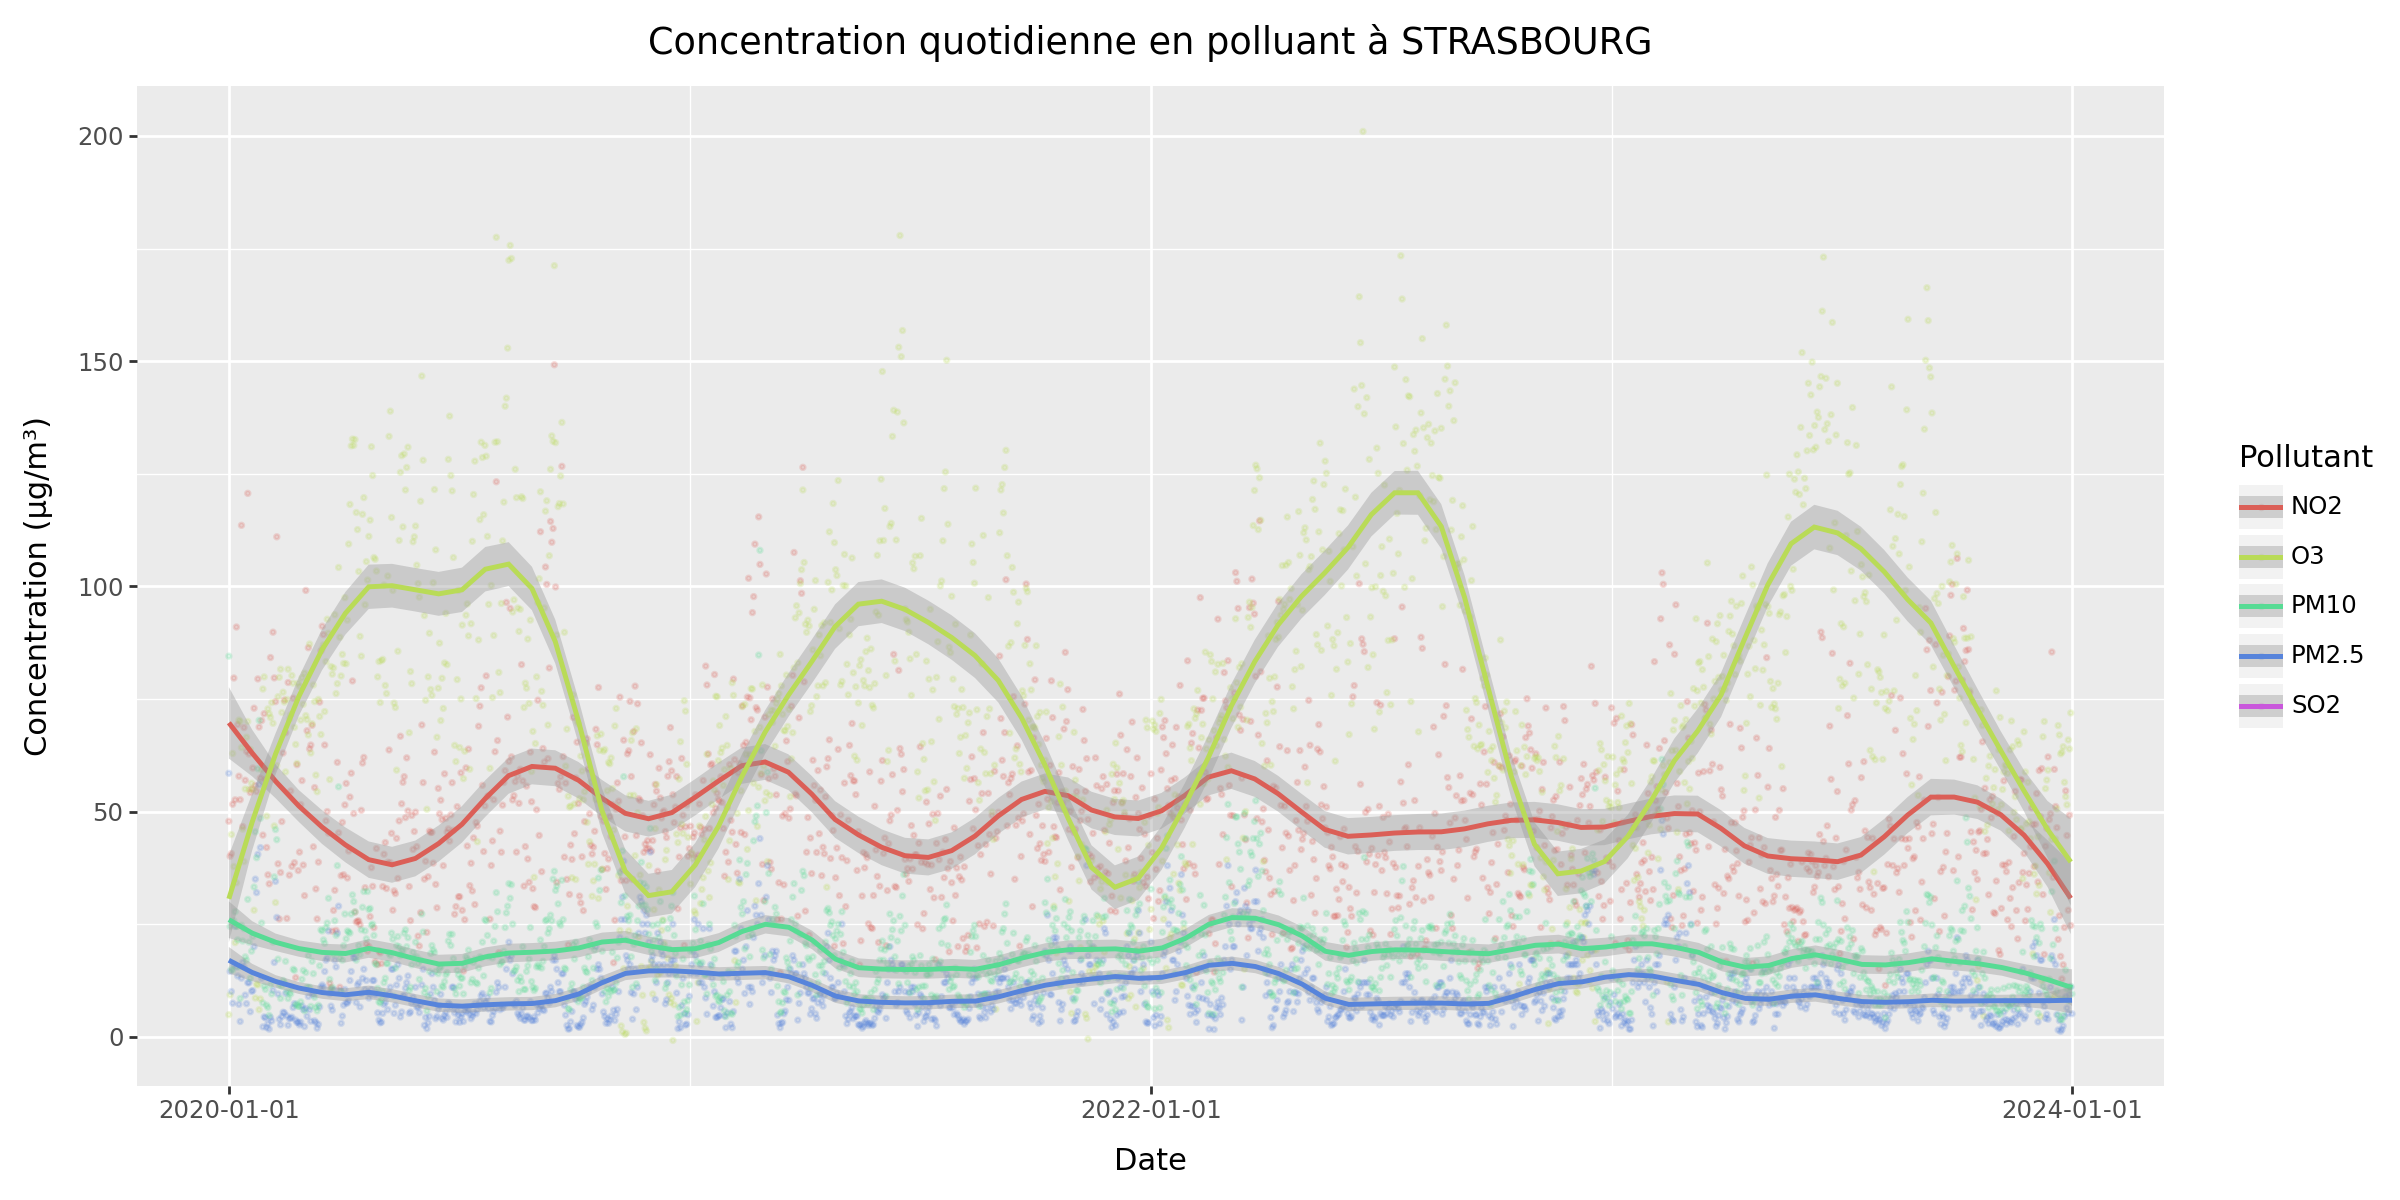

In [19]:
from plotnine import ggplot, aes, geom_point, geom_smooth, theme_minimal, labs, theme



def plot_pollutants_ggplot(df, smoothing = 0.15):

    # On Melt le dataframe pour simplifier le plotting avec plotnine
    melted_df = df.melt(id_vars='date',
                        value_vars=['NO2', 'O3', 'PM2.5', 'PM10', 'SO2'],
                        var_name='Polluant',
                        value_name='Concentration')
    
    ville = str(df[['nom_m']].iloc[0,0])

    # On crée ggplot
    p = (ggplot(melted_df, aes(x='date', y='Concentration', color='Polluant'))
         + geom_point(alpha=0.2, size=0.5)  # Points
         + geom_smooth(method='loess', span = smoothing,se=True, size=1)  # Smoothed lines
         + labs(title=f'Concentration quotidienne en polluant à {ville}',
                x='Date',
                y='Concentration (µg/m³)',
                color='Pollutant')
         + theme(figure_size=(12, 6))                            
         )
         
    return p



data = Y_t[(Y_t['nom_m'] == 'STRASBOURG')]
# Si on veut visualiser la log-concentration, on peut utiliser la commande suivante:
#data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']] = np.log(data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']])
plot_pollutants_ggplot(data)


Un deuxième et troisième exemple avec Paris et Massy

In [18]:
data = Y_t[(Y_t['nom_m'] == 'PARIS')]
# Si on veut visualiser la log-concentration, on peut utiliser la commande suivante:
#data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']] = np.log(data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']])
plot_pollutants_ggplot(data)

NameError: name 'plot_pollutants_ggplot' is not defined

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 51 rows containing missing values.


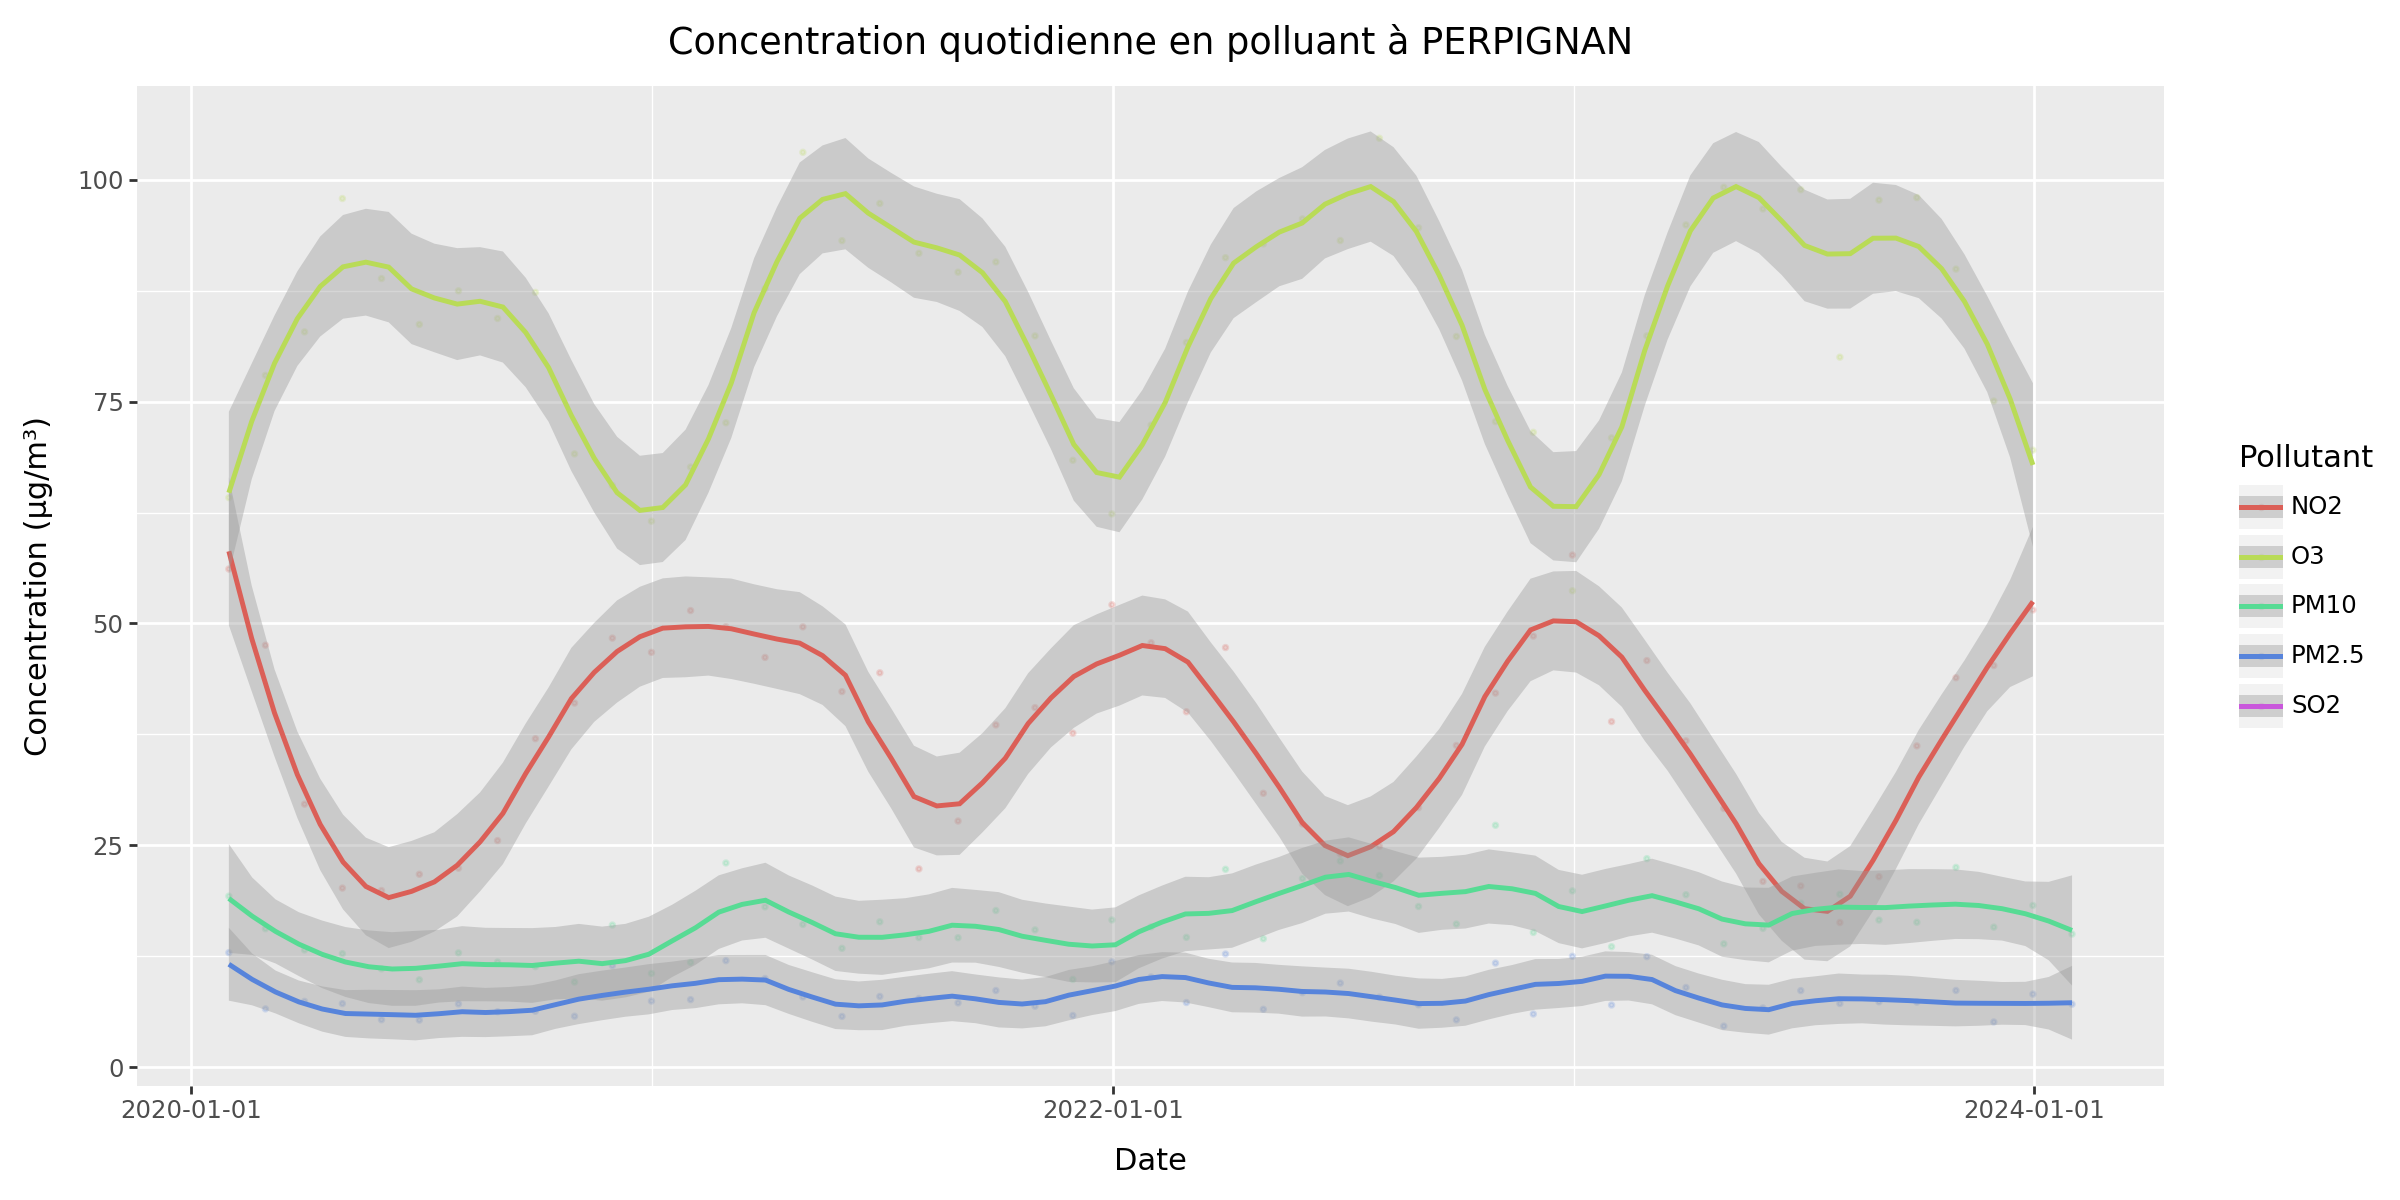

In [20]:

ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Si on veut visualiser la log-concentration, on peut utiliser la commande suivante:
#data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']] = np.log(data[['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']])
#plot_pollutants_ggplot(monthly_data)
monthly_data['nom_m'] = ville
plot_pollutants_ggplot(monthly_data, smoothing=0.2)

--> Observation

In [ ]:
# On regroupe par donées mensuells
ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Exemple : Chargement des données environnementales
# Remplacez cela par votre dataset réel
data = monthly_data

data.set_index('date', inplace=True)

# Définir la fréquence journalière
data.index.freq = 'M'

# Vérifiez votre colonne cible (par ex., 'NO2')
target_variable = 'NO2'

# Diviser les données en train/test si nécessaire
train = data[target_variable].loc[:'2022-12-31']

test = data[target_variable].loc['2023-01-01':]
'''
# Configurer et ajuster le modèle SARIMAX (saisonnier)
model = sm.tsa.statespace.SARIMAX(train, 
                order=(0, 2, 1),  # p, d, q
                seasonal_order=(1, 0, 0, 12),  # P, D, Q, S (S = saisonnalité annuelle pour les données journalières)
                enforce_stationarity=False, 
                enforce_invertibility=False)
'''
# Modèle non saisonnier
model = sm.tsa.statespace.SARIMAX(train, 
                order=(2, 1, 3),  # p, d, q
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit(disp=False)

# Résumé du modèle
print(results.summary())


date
2020-01-31    56.135484
2020-02-29    47.548276
2020-03-31    29.637097
2020-04-30    20.185000
2020-05-31    19.909677
2020-06-30    21.740000
2020-07-31    22.420968
2020-08-31    25.533871
2020-09-30    37.016667
2020-10-31    41.029032
2020-11-30    48.351667
2020-12-31    46.745161
2021-01-31    51.452688
2021-02-28    49.633333
2021-03-31    46.171505
2021-04-30    49.617222
2021-05-31    42.322581
2021-06-30    44.439444
2021-07-31    22.341935
2021-08-31    27.738710
2021-09-30    38.563333
2021-10-31    40.519355
2021-11-30    37.640000
2021-12-31    52.106452
2022-01-31    47.822581
2022-02-28    40.050000
2022-03-31    47.283871
2022-04-30    30.863333
2022-05-31    27.400000
2022-06-30    24.045833
2022-07-31    24.893333
2022-08-31    29.238710
2022-09-30    36.255172
2022-10-31    42.148387
2022-11-30    48.573333
2022-12-31    57.706452
Freq: ME, Name: NO2, dtype: float64

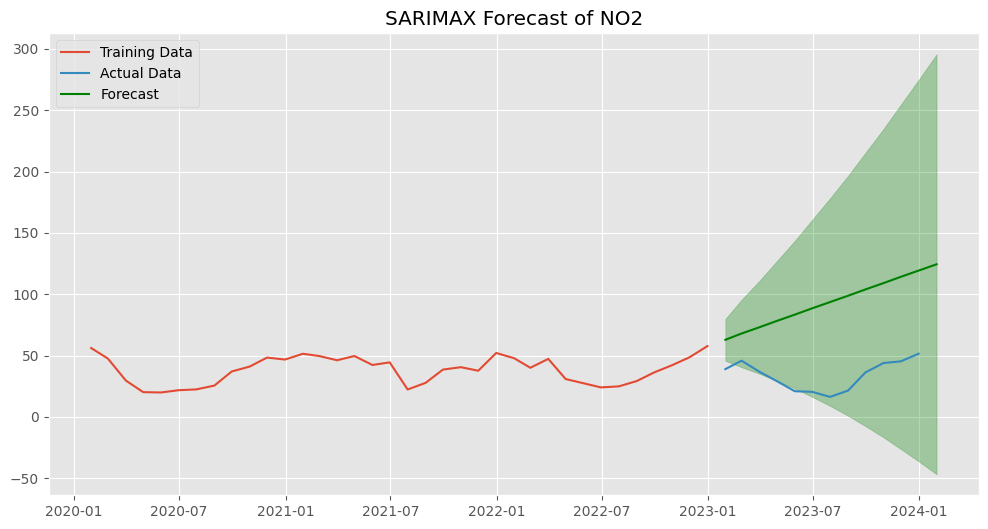

In [98]:
# Faire des prédictions
forecast = results.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data')
plt.plot(forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='green', alpha=0.3)
plt.legend()
plt.title(f'SARIMAX Forecast of {target_variable}')
plt.show()



In [102]:
# ON va essayer de voir quel modèle est le plus efficae (minimisation de AIC)
p = 6
q = 6
d = 3
print(eval_model(train,P = p,Q = q,D = d))
#print(select_model(train,P = p,Q = q,D = d))
#Le modèle réusltant pour Perpignan (asn compter la partie exogène X_t est (0,2,1))
# Nous n'avons pas la capacité computationnelles de produire une modèle saisonnier


          AIC Model
0  263.865157   100
1  252.658259   213
2  250.274576   021


In [ ]:
# On va maintenant ajouter les données exogènes (sur X_t):
# On regroupe par donées mensuells
'''
ville = 'PERPIGNAN'
data = Y_t[(Y_t['nom_m'] == ville)]
data.set_index('date', inplace=True)
monthly_data = data.resample('ME').mean(numeric_only=True)
monthly_data.reset_index(inplace=True)
# Exemple : Chargement des données environnementales
'''
def arima_mensuel(df, ville):
    '''Une fonction qui transforme les données quotidiennes en données mensuelles, utilisatble pour ARIMA
        ville doit être entré en MAJUSCULES entre guillemets, exemple : vers_mensuel(Y_t, 'PERPIGNAN')
    '''
    data = df[df['nom_m']==ville]
    data.set_index('date', inplace = True)
    data_mensuel = data.resample('ME').mean(numeric_only=True)
    data_mensuel.reset_index(inplace=True)
    data_mensuel.index.freq = 'M'
    data_mensuel.set_index('date', inplace=True)
    return data_mensuel

target_variable = 'NO2'
exog_variables = ['pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]

exog_data =arima_mensuel(X_t, 'PERPIGNAN').loc[:, exog_variables].dropna() 
exog = sm.add_constant(exog_data)
endog = arima_mensuel(Y_t, 'PERPIGNAN').loc[exog_data.index,target_variable]
# Modèle non saisonnier
model = sm.tsa.statespace.SARIMAX(endog, exog,
                order=(1, 0, 1),  # p, d, q
                seasonal_order = (1,0,0,12),
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit(disp=False)

# Résumé du modèle
print(results.summary())



c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


                                      SARIMAX Results                                      
Dep. Variable:                                 NO2   No. Observations:                   48
Model:             SARIMAX(1, 0, 2)x(1, 1, [], 12)   Log Likelihood                 -67.304
Date:                             Tue, 24 Dec 2024   AIC                            162.609
Time:                                     16:14:12   BIC                            178.506
Sample:                                 01-31-2020   HQIC                           166.607
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          4.017e-08      0.000      0.000      

In [139]:
hyp_param = select_model_optimized(endog = endog,exog =  exog, P = 5, Q = 5, D = 3)
hyp_param

(1, 1, 0)

Automatisation de la démarche

In [29]:
# Filter the dataframe for entries with 'population' > 10000
filtered_Y_t = Y_t[Y_t['population'] > 10000]

# Randomly sample 3 unique values of 'nom_m' from the filtered dataframe
sampled_nom_m = filtered_Y_t['nom_m'].drop_duplicates().sample(n=3, random_state=42)

# Subset the original dataframe to include only the sampled 'nom_m' time series
Y_t_sample = Y_t[Y_t['nom_m'].isin(sampled_nom_m)]

# Reset the index for the sampled dataframe
Y_t_sample.reset_index(drop=True, inplace=True)

Y_t_sample

,index,date,nom_m,NO2,O3,PM2.5,PM10,SO2,population
0,11681,2020-01-01,ANGERS,25.90,52.4,16.0,18.0,NaN,157175
1,11682,2020-01-02,ANGERS,26.50,61.1,9.3,14.0,NaN,157175
2,11683,2020-01-03,ANGERS,23.90,70.8,6.9,12.0,NaN,157175
3,11684,2020-01-04,ANGERS,68.35,73.1,13.0,21.0,NaN,157175
4,11685,2020-01-05,ANGERS,40.55,75.7,11.0,14.0,NaN,157175
...,...,...,...,...,...,...,...,...,...
4380,396207,2023-12-28,PORT-JEROME-SUR-SEINE,35.20,NaN,NaN,18.0,151.1,10387
4381,396208,2023-12-29,PORT-JEROME-SUR-SEINE,27.80,NaN,NaN,13.0,166.4,10387
4382,396209,2023-12-30,PORT-JEROME-SUR-SEINE,19.50,NaN,NaN,9.0,95.6,10387
4383,396210,2023-12-31,PORT-JEROME-SUR-SEINE,27.60,NaN,NaN,9.0,95.1,10387


In [ ]:
from statistics import mode


target_variable = 'NO2'
exog_variables = ['pression_niveau_mer_Pa',
    'var_pression_3h_Pa',
    'direction_vent_moyen_10mn_deg',
    'vitesse_vent_moyen_10mn_m/s',
    'temperature_K',
    'humidite_%',
    'visibilite_horizontale_m',
    'precipitations_24h_mm'
    ]

exog_data =arima_mensuel(X_t, ville).loc[:, exog_variables].dropna() 
exog = sm.add_constant(exog_data)
endog = arima_mensuel(Y_t, ville).loc[exog_data.index,target_variable]

for ville in list(Y_t_sample['nom_m']):
    #Set pour gagner en vitesse d'exécution
    set_hyp_param = []

    #On calcule le modèle optimal pour l'échantillon de villes
    exog_data =arima_mensuel(X_t, ville).loc[:, exog_variables].dropna() 
    exog = sm.add_constant(exog_data)
    endog = arima_mensuel(Y_t, ville).loc[exog_data.index,target_variable]
    set_hyp_param.append(select_model_optimized(endog = endog,exog =  exog, P = 5, Q = 5, D = 3))
    result = mode(set_hyp_param)

result


In [ ]:
hyper_parametres = (1,1,1)
ville = 'PERPIGNAN'
polluant = 'NO2'

def resultat_arimax(Y,X = None, polluant ='NO2', ville = 'STRASBOURG'):
    '''
    Cette fonction calcule les coefficiens ARIMA sachant les paramètres du modèles donnés.
    Elle revoit un dataframe contenant les valeurs estimées du modèles (coefficients et p-valeurs)
    '''
    exog_variables = ['pression_niveau_mer_Pa',
                      'var_pression_3h_Pa',
                      'direction_vent_moyen_10mn_deg',
                      'vitesse_vent_moyen_10mn_m/s',
                      'temperature_K',
                      'humidite_%',
                      'visibilite_horizontale_m',
                      'precipitations_24h_mm'
                    ]

    # On traite les données exogènes
    exog_data =arima_mensuel(X, ville).loc[:, exog_variables].dropna()

    # On traite les données endogènes
    exog = sm.add_constant(exog_data)

    # On aligne les indice de endog et exog 
    endog = arima_mensuel(Y, ville).loc[exog_data.index,polluant]    

    # Modèle non saisonnier
    model = sm.tsa.statespace.SARIMAX(endog, exog,
                    order=(1, 0, 1),  # p, d, q
                    seasonal_order = (1,0,0,12),
                    enforce_stationarity=False, 
                    enforce_invertibility=False)

    results = model.fit(disp=False)
    return pd.DataFrame({
        'nom_m':ville, 
        'polluant':polluant,
        'coefficiens' : results.params,
        'p-valeurs' : results.pvalues
        })

resultat_arimax(Y_t,X_t,polluant=polluant,ville = ville)

def get_hyper_param_liste(Y,X):
    '''
    Cette fonction permet d'obtenir les paramètres optimaux pour la sélection du modèle arima pour chaque polluant
    Dans l'ordre: 'NO2','O3','PM2.5','PM10'.
    '''
    hyper_param_liste = []
    return hyper_param_liste

def arima_tout_polluants(Y,X, ville):
    '''
    Cette fonction renvoie un dataframe contenant les résultat de l'estimation ARIMAX pour les paramètres spécifiés du modèle
    L'argument 'hyper_param_list' est une liste contenant les tuples correspondant aux hyperparamètres optimaux pour chaques polluant 
    (dans l'ordre : 'NO2','O3','PM2.5','PM10').
    '''
    polluant = ['NO2','O3','PM2.5','PM10']
    liste_arima_resultats = [
        resultat_arimax(Y,X,polluant=polluant[i], ville = ville)
        for i in range(4)
    ]
    output = pd.concat(liste_arima_resultats)
    return output
#Cette fonction fonctionne bien

def modelisation_arima(Y,X):
    '''
    Cette fonction calcule les coefficients et p-valeurs pour chaque les villes du jeu dont la population est supérieure à pop_min (int)
    Elle renvoie le résultat sous forme de dataframe
    '''
    
    liste_arima_resultat_ville = [arima_tout_polluants( Y,X,ville) for ville in list(Y['nom_m'])]
    output = pd.concat(liste_arima_resultat_ville)
    return output

#modelisation_arima(Y_t_sample,X_t)

Y_t_super_pop = Y_t[Y_t['population'] > 100000]
# Reset the index for the sampled dataframe
Y_t_super_pop.reset_index(drop=True, inplace=True)
villes_super_pop = list(Y_t_super_pop['nom_m'].unique())
modelisations = []

for ville in villes_super_pop:
    try :
        modelisations.append(resultat_arimax(Y_t,X_t, polluant='NO2',ville = ville))
        print(f"Le modèle a été calculé pour {ville}")
    except:
        print(f"Le modèle n'a pas pu être calculé pour {ville}")
resultat = pd.concat(modelisations)
resultat.reset_index(inplace = True)
resultat.rename(columns={'index':'parametre'}, inplace=True)
resultat = pd.pivot(resultat,index='nom_m',columns='parametre',values = ['coefficiens','p-valeurs'])
resultat

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour PARIS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour STRASBOURG
Le modèle a été calculé pour PERPIGNAN


coefficiens                                                      \
parametre        ar.L1  ar.S.L12       const direction_vent_moyen_10mn_deg   
nom_m                                                                        
PARIS        -0.209094  0.158113   48.851279                      0.040461   
PERPIGNAN     0.564551  0.021328  223.785936                      0.167164   
STRASBOURG   -0.336204  0.425502 -299.383364                     -0.004288   

                                                                              \
parametre  humidite_%     ma.L1 precipitations_24h_mm pression_niveau_mer_Pa   
nom_m                                                                          
PARIS       -0.096324  0.468827              1.220750               0.003572   
PERPIGNAN   -0.072593 -0.069402             -1.631461               0.002832   
STRASBOURG   0.224794  0.680622             -1.585449               0.004702   

                                     ...                     p-valeurs  \
parametre      sigma2 temperature_K  ... direction_vent_moyen_10mn_deg   
nom_m                                ...                                 
PARIS       32.557658     -1.209769  ...                      0.404456   
PERPIGNAN   26.892978     -1.645190  ...                      0.289209   
STRASBOURG  38.084478     -0.494825  ...                      0.940640   

                                                                              \
parametre  humidite_%     ma.L1 precipitations_24h_mm pression_niveau_mer_Pa   
nom_m                                                                          
PARIS        0.728885  0.526159              0.499700               0.024720   
PERPIGNAN    0.894781  0.941829              0.276017               0.084559   
STRASBOURG   0.505141  0.514214              0.655127               0.514669   

                                                       \
parametre     sigma2 temperature_K var_pression_3h_Pa   
nom_m                                                   
PARIS       0.022975      0.038233           0.829558   
PERPIGNAN   0.011929      0.000196           0.166856   
STRASBOURG  0.053190      0.659200           0.283517   

                                                                 
parametre  visibilite_horizontale_m vitesse_vent_moyen_10mn_m/s  
nom_m                                                            
PARIS                      0.423972                    0.009428  
PERPIGNAN                  0.553109                    0.037635  
STRASBOURG                 0.900595                    0.656919  

[3 rows x 26 columns]

In [70]:
import random

# On sélectionne les villes en France de plus de 100k hoabitants
Y_t_super_pop = Y_t[Y_t['population'] > 100000]
# Reset the index for the sampled dataframe
Y_t_super_pop.reset_index(drop=True, inplace=True)
# On sélectionne d'abord 15 parmis les 37 villes
villes_super_pop = random.sample(list(Y_t_super_pop['nom_m'].unique()),15)
villes_super_pop_all = list(Y_t_super_pop['nom_m'].unique())

# On procède à la modélisation
modelisations = []
for ville in villes_super_pop_all:
    try :
        modelisations.append(resultat_arimax(Y_t,X_t, polluant='NO2',ville = ville))
        print(f"Le modèle a été calculé pour {ville}")
    except:
        print(f"Le modèle n'a pas pu être calculé pour {ville}")
resultat = pd.concat(modelisations)
resultat.reset_index(inplace = True)
resultat.rename(columns={'index':'parametre'}, inplace=True)
resultat = pd.pivot(resultat,index='nom_m',columns='parametre',values = ['coefficiens','p-valeurs'])
resultat

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour AIX-EN-PROVENCE
Le modèle a été calculé pour AMIENS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour ANGERS
Le modèle a été calculé pour ANNECY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


Le modèle a été calculé pour ARGENTEUIL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BESANCON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour BORDEAUX
Le modèle a été calculé pour BREST


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CAEN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CLERMONT-FERRAND


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour DIJON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour GRENOBLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LE HAVRE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour LE MANS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LILLE
Le modèle a été calculé pour LIMOGES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LYON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MARSEILLE
Le modèle a été calculé pour METZ


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour MONTPELLIER


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MULHOUSE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour NANCY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour NANTES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour NICE
Le modèle a été calculé pour NIMES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour ORLEANS
Le modèle a été calculé pour PARIS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour PERPIGNAN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour REIMS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour RENNES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour ROUEN
Le modèle n'a pas pu être calculé pour SAINT-ETIENNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour STRASBOURG
Le modèle n'a pas pu être calculé pour TOULON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour TOULOUSE
Le modèle a été calculé pour TOURS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour VILLEURBANNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


coefficiens                         \
parametre              ar.L1  ar.S.L12        const   
nom_m                                                 
AIX-EN-PROVENCE     0.082021  0.095651 -1381.803224   
AMIENS              0.328176  0.367052   325.904345   
ANGERS              0.058751  0.316216   121.627264   
ANNECY             -0.000409  0.190873 -1364.320526   
ARGENTEUIL          0.102364 -0.061173   279.303254   
BESANCON            0.075454  0.213564  -484.694958   
BORDEAUX           -0.175375  0.019001  -578.158806   
BREST               0.244757  0.405148  -112.846842   
CAEN                0.639098  0.320294   190.608558   
CLERMONT-FERRAND   -0.779745  0.491323  -896.981173   
DIJON               0.111908  0.412658  -385.911985   
GRENOBLE            0.319871 -0.003978 -1403.247228   
LE HAVRE            0.144180  0.455367    91.552398   
LE MANS             0.185890  0.351527   174.068215   
LILLE               0.075546  0.168362  -303.083578   
LIMOGES            -0.082711  0.208498  -365.260480   
LYON                0.045996  0.375909 -1552.967491   
MARSEILLE           0.274006 -0.042180  -909.382242   
METZ                0.089579  0.407288  -206.864715   
MONTPELLIER         0.510979  0.129360 -1373.405496   
MULHOUSE            0.124049  0.262592  -144.494304   
NANCY              -0.113661  0.334798   -50.540759   
NANTES              0.229472  0.192738   -57.884832   
NICE                0.078333 -0.074369   -44.130865   
NIMES               0.089948  0.087888  -841.684529   
ORLEANS            -0.106264  0.359192   -21.159027   
PARIS              -0.209094  0.158113    48.851279   
PERPIGNAN           0.564551  0.021328   223.785936   
REIMS               0.103831  0.313269  -508.845264   
RENNES             -1.028553 -0.063845  -121.768537   
ROUEN               0.024898  0.280396    74.801579   
STRASBOURG         -0.336204  0.425502  -299.383364   
TOULOUSE            0.335864  0.134145  -440.051124   
TOURS              -0.080493  0.441231   -90.414526   
VILLEURBANNE        0.050022  0.191150  -681.365428   

                                                                     \
parametre        direction_vent_moyen_10mn_deg humidite_%     ma.L1   
nom_m                                                                 
AIX-EN-PROVENCE                       0.025909   0.513680  0.390626   
AMIENS                                0.042636  -0.136875  0.247142   
ANGERS                               -0.053032   0.363194  0.348908   
ANNECY                               -0.075836  -0.133556  0.350307   
ARGENTEUIL                            0.059052  -0.185643  0.256646   
BESANCON                             -0.031054  -0.232071  0.246818   
BORDEAUX                             -0.073107   0.258708  0.459233   
BREST                                 0.000525   0.527001 -0.060356   
CAEN                                  0.036756   0.176793 -0.394453   
CLERMONT-FERRAND                      0.038225   0.143054  1.028267   
DIJON                                 0.013209   0.040676  0.307802   
GRENOBLE                             -0.081435   0.128973  0.064598   
LE HAVRE                             -0.013648   0.460877  0.044845   
LE MANS                               0.068746   0.036494 -0.062116   
LILLE                                -0.139152   0.415140  0.218206   
LIMOGES                              -0.126991   0.419351  0.571981   
LYON                                 -0.078082   0.010965  0.375616   
MARSEILLE                            -0.040313  -0.162815  0.109668   
METZ                                 -0.086136   0.013827  0.336663   
MONTPELLIER                           0.079358   0.289912  0.073860   
MULHOUSE                             -0.164805   0.324075  0.389936   
NANCY                                -0.087261   0.024563  0.561660   
NANTES                               -0.010831   0.614580  0.270122   
NICE                                  0.150168  -0.101005  0.146215   
NIMES    

In [72]:
#Enfin, on peut essayer de faire la même chose mais pour toutes les villes de france de plus de 2000 habitants
# On sélectionne les villes en France de plus de 100k hoabitants
Y_t_sup_1000 = Y_t[Y_t['population'] > 1000]
# Reset the index for the sampled dataframe
Y_t_sup_1000.reset_index(drop=True, inplace=True)
# On sélectionne d'abord 15 parmis les 37 villes
villes_super_pop = random.sample(list(Y_t_sup_1000['nom_m'].unique()),15)
villes_super_pop_all = list(Y_t_sup_1000['nom_m'].unique())

# On procède à la modélisation
modelisations = []
for ville in villes_super_pop_all:
    try :
        modelisations.append(resultat_arimax(Y_t,X_t, polluant='NO2',ville = ville))
        print(f"Le modèle a été calculé pour {ville}")
    except:
        print(f"Le modèle n'a pas pu être calculé pour {ville}")
resultat = pd.concat(modelisations)
resultat.reset_index(inplace = True)
resultat.rename(columns={'index':'parametre'}, inplace=True)
resultat = pd.pivot(resultat,index='nom_m',columns='parametre',values = ['coefficiens','p-valeurs'])
resultat

c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour AGDE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour AIRVAULT
Le modèle a été calculé pour AIX-EN-PROVENCE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour AJACCIO
Le modèle n'a pas pu être calculé pour ALBERTVILLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour ALBI


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour AMBES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour AMIENS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour ANGERS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour ANGLET
Le modèle a été calculé pour ANGOULEME
Le modèle a été calculé pour ANNECY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour ANNEMASSE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour ANTIBES
Le modèle a été calculé pour APT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


Le modèle a été calculé pour ARGENTEUIL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour ARLES
Le modèle a été calculé pour AUBAGNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour AUBERVILLIERS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour AURILLAC
Le modèle a été calculé pour AUXERRE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour AVIGNON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour AYTRE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BAIE-MAHAULT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour BAR-LE-DUC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BASSE-TERRE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been

Le modèle a été calculé pour BASSENS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


Le modèle a été calculé pour BASTIA


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide


Le modèle a été calculé pour BAUME-LES-DAMES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour BAYONNE
Le modèle a été calculé pour BEAUTHEIL-SAINTS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour BEAUVAIS
Le modèle a été calculé pour BELFORT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour BELLEVILLE-SUR-MEUSE
Le modèle a été calculé pour BERRE-L'ETANG


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BESANCON
Le modèle a été calculé pour BESSIERES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour BETHENY
Le modèle a été calculé pour BETHUNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour BIARRITZ


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour BILLERE
Le modèle a été calculé pour BLAGNAC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour BLENOD-LES-PONT-A-MOUSSON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BLOIS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BOBIGNY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour BORDEAUX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour BOUAYE
Le modèle a été calculé pour BOUCHEMAINE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BOUGUENAIS
Le modèle a été calculé pour BOULOGNE-SUR-MER


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour BOURG-EN-BRESSE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour BOURG-LES-VALENCE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BOURGES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour BOURGOIN-JALLIEU
Le modèle a été calculé pour BREST
Le modèle n'a pas pu être calculé pour BRIGNOLES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour BRIVE-LA-GAILLARDE
Le modèle a été calculé pour BRUNSTATT-DIDENHEIM


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour CAEN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour CALAIS
Le modèle a été calculé pour CANNES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour CAPPELLE-LA-GRANDE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour CARLING
Le modèle a été calculé pour CARPENTRAS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CARTIGNIES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour CAYENNE
Le modèle a été calculé pour CERGY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CHALON-SUR-SAONE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour CHALONS-EN-CHAMPAGNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour CHAMALIERES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour CHAMBERY
Le modèle n'a pas pu être calculé pour CHAMONIX-MONT-BLANC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour CHAMP-SUR-DRAC
Le modèle a été calculé pour CHAMPFORGEUIL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour CHAMPIGNY-SUR-MARNE
Le modèle a été calculé pour CHANCEAUX-SUR-CHOISILLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour CHARLEVILLE-MEZIERES
Le modèle a été calculé pour CHARTRES
Le modèle a été calculé pour CHATEAUNEUF-LES-MARTIGUES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour CHATEAUROUX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CHERBOURG-EN-COTENTIN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CHOLET
Le modèle a été calculé pour CLERMONT-FERRAND
Le modèle a été calculé pour COLMAR


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour CORNEILHAN
Le modèle a été calculé pour COULOMMIERS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CREIL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour CROLLES
Le modèle a été calculé pour DAIX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour DAMPARIS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour DAX
Le modèle a été calculé pour DENAIN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour DIEPPE
Le modèle a été calculé pour DIJON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour DOLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour DONGES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour DOUAI


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour DREUX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour DUNKERQUE
Le modèle a été calculé pour ECHIROLLES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour EPERNAY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour EPINAL
Le modèle a été calculé pour EVREUX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour EVRY-COURCOURONNES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour EYBENS
Le modèle a été calculé pour FECAMP


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour FEYZIN
Le modèle a été calculé pour FLEVILLE-DEVANT-NANCY
Le modèle a été calculé pour FLOIRAC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour FONTAINEBLEAU


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour FORBACH


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour FORT-DE-FRANCE
Le modèle a été calculé pour FOS-SUR-MER


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour FREJUS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour FROSSAY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour GAILLARD
Le modèle n'a pas pu être calculé pour GAP
Le modèle a été calculé pour GARDANNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour GEISPOLSHEIM
Le modèle a été calculé pour GENNEVILLIERS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour GONESSE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour GONFREVILLE-L'ORCHER
Le modèle a été calculé pour GRAND-COURONNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour GRANDE-SYNTHE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour GRASSE
Le modèle a été calculé pour GRAVELINES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour GRENOBLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour GUERET
Le modèle a été calculé pour HAGUENAU


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour HALLUIN
Le modèle a été calculé pour HARFLEUR


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour HARNES
Le modèle a été calculé pour HAYANGE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour HONFLEUR
Le modèle n'a pas pu être calculé pour HYERES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour IFS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour ISSOUDUN
Le modèle a été calculé pour ISTRES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour JOUE-LES-TOURS
Le modèle a été calculé pour KOUROU


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour L'HOPITAL
Le modèle a été calculé pour LA CALMETTE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour LA CERLANGUE
Le modèle n'a pas pu être calculé pour LA COURONNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle n'a pas pu être calculé pour LA LECHERE
Le modèle a été calculé pour LA MULATIERE
Le modèle a été calculé pour LA PENNE-SUR-HUVEAUNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour LA POSSESSION


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour LA ROCHE-SUR-YON
Le modèle n'a pas pu être calculé pour LA SEYNE-SUR-MER


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour LA TALAUDIERE
Le modèle n'a pas pu être calculé pour LA VALETTE-DU-VAR


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LATTES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour LAVAL
Le modèle a été calculé pour LE CREUSOT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LE HAVRE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour LE LAMENTIN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour LE MANS
Le modèle a été calculé pour LE MESNIL-ESNARD
Le modèle n'a pas pu être calculé pour LE MONETIER-LES-BAINS
Le modèle a été calculé pour LE PALAIS-SUR-VIENNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour LE PETIT-QUEVILLY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour LE PONTET
Le modèle n'a pas pu être calculé pour LE PUY-EN-VELAY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour LE ROBERT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour LE TAMPON
Le modèle a été calculé pour LENS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


Le modèle a été calculé pour LES ABYMES
Le modèle a été calculé pour LES ANCIZES-COMPS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle n'a pas pu être calculé pour LES BELLEVILLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LES ROCHES-DE-CONDRIEU
Le modèle a été calculé pour LES ULIS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour LILLE
Le modèle a été calculé pour LILLEBONNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LIMOGES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour LISIEUX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour LOGNES
Le modèle a été calculé pour LONS-LE-SAUNIER


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_mo

Le modèle a été calculé pour LORIENT
Le modèle a été calculé pour LOURDES
Le modèle a été calculé pour LUCCIANA


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_mo

Le modèle a été calculé pour LUNEL-VIEL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LUNEVILLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour LYON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been

Le modèle a été calculé pour MACON
Le modèle a été calculé pour MACOURIA


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MAMOUDZOU


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MANOSQUE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour MANTES-LA-JOLIE
Le modèle a été calculé pour MARCQ-EN-BARŒUL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MARIGNANE
Le modèle a été calculé pour MARIGNY-LES-USAGES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MARMANDE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MARSEILLE
Le modèle a été calculé pour MARTIGUES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MATOURY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MAUBEUGE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MELUN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MERIGNAC
Le modèle a été calculé pour METZ
Le modèle n'a pas pu être calculé pour MIRAMAS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\

Le modèle a été calculé pour MIRIBEL
Le modèle a été calculé pour MONDEVILLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MONT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour MONT-DE-MARSAN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MONTARGIS
Le modèle a été calculé pour MONTAUBAN
Le modèle a été calculé pour MONTBELIARD


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MONTCEAU-LES-MINES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour MONTGERON
Le modèle a été calculé pour MONTGISCARD


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour MONTIERCHAUME
Le modèle a été calculé pour MONTLHERY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MONTLUCON
Le modèle a été calculé pour MONTOIR-DE-BRETAGNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MONTPELLIER
Le modèle a été calculé pour MORDELLES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour MOULT-CHICHEBOVILLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour MOURENX
Le modèle a été calculé pour MULHOUSE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour NANCY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divid

Le modèle a été calculé pour NANTES
Le modèle a été calculé pour NEUILLY-SAINT-FRONT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour NEUILLY-SUR-SEINE
Le modèle a été calculé pour NEUVES-MAISONS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour NEVERS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour NICE
Le modèle a été calculé pour NIMES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour NIORT
Le modèle a été calculé pour NOGENT-SUR-MARNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour NOGENT-SUR-OISE
Le modèle a été calculé pour NUITS-SAINT-GEORGES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour ORLEANS
Le modèle a été calculé pour OUISTREHAM


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour OUTREAU
Le modèle a été calculé pour PAIMBŒUF


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour PANTIN
Le modèle a été calculé pour PARIS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour PAU
Le modèle a été calculé pour PEILLON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour PERIGUEUX
Le modèle a été calculé pour PERPIGNAN
Le modèle a été calculé pour PETIT-COURONNE
Le modèle n'a pas pu être calculé pour PLAN-D'AUPS-SAINTE-BAUME


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances w

Le modèle a été calculé pour PLOUZANE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour POINTE-A-PITRE
Le modèle a été calculé pour POITIERS
Le modèle a été calculé pour PONT-A-MOUSSON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour PORNICHET
Le modèle a été calculé pour PORT-DE-BOUC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour PORT-JEROME-SUR-SEINE
Le modèle a été calculé pour PORT-SAINT-LOUIS-DU-RHONE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour PORTES-LES-VALENCE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


Le modèle a été calculé pour PUSIGNAN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour PUTEAUX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour QUIMPER
Le modèle a été calculé pour RAMBOUILLET


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour REIMS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour REMIREMONT


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour RENNES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour REZE
Le modèle a été calculé pour RIOM


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour RIVE-DE-GIER
Le modèle a été calculé pour ROANNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour RODEZ
Le modèle a été calculé pour ROGERVILLE
Le modèle a été calculé pour ROGNAC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour ROMANS-SUR-ISERE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour ROUBAIX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour ROUEN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour ROUSSILLON
Le modèle a été calculé pour ROYAT
Le modèle a été calculé pour ROYE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SAINT-AMAND-LES-EAUX
Le modèle a été calculé pour SAINT-BRIEUC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances w

Le modèle a été calculé pour SAINT-CHAMOND


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour SAINT-DENIS-D'ANJOU


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour SAINT-DIZIER
Le modèle a été calculé pour SAINT-ESTEVE
Le modèle n'a pas pu être calculé pour SAINT-ETIENNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour SAINT-ETIENNE-DE-MONTLUC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour SAINT-FONS
Le modèle a été calculé pour SAINT-GAUDENS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SAINT-GELY-DU-FESC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters fo

Le modèle a été calculé pour SAINT-JEAN-DE-BRAYE
Le modèle a été calculé pour SAINT-JEAN-DE-LA-RUELLE
Le modèle n'a pas pu être calculé pour SAINT-JEAN-DE-MAURIENNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set t

Le modèle a été calculé pour SAINT-JULIEN-LES-METZ


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour SAINT-JUNIEN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour SAINT-LAURENT-BLANGY
Le modèle a été calculé pour SAINT-LAURENT-DES-ARBRES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour SAINT-LEU
Le modèle a été calculé pour SAINT-LO


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour SAINT-MALO
Le modèle a été calculé pour SAINT-MARTIN-D'HERES
Le modèle a été calculé pour SAINT-MARTIN-DU-TERTRE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle n'a pas pu être calculé pour SAINT-MICHEL-DE-MAURIENNE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour SAINT-MICHEL-L'OBSERVATOIRE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SAINT-NICOLAS-DE-PORT
Le modèle a été calculé pour SAINT-PARRES-AUX-TERTRES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour SAINT-QUENTIN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour SAINT-REMY-SUR-AVRE
Le modèle a été calculé pour SAINT-ROMAIN-DE-COLBOSC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SAINTE-ADRESSE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour SAINTE-LUCE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour SAINTE-SAVINE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SAINTES-MARIES-DE-LA-MER
Le modèle a été calculé pour SALAISE-SUR-SANNE
Le modèle a été calculé pour SALON-DE-PROVENCE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check ml

Le modèle a été calculé pour SALOUEL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour SANGATTE
Le modèle a été calculé pour SARREGUEMINES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SARROLA-CARCOPINO
Le modèle a été calculé pour SAUSSET-LES-PINS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SAVENAY
Le modèle a été calculé pour SAZE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SCHŒLCHER
Le modèle a été calculé pour SCHŒNECK


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour SCY-CHAZELLES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_mo

Le modèle a été calculé pour SENS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour SONCHAMP
Le modèle a été calculé pour SOTTEVILLE-LES-ROUEN
Le modèle a été calculé pour SPAY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour SPICHEREN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been

Le modèle a été calculé pour STRASBOURG


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour TALENCE
Le modèle a été calculé pour TANCARVILLE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour TARBES
Le modèle a été calculé pour TARTAS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour TAVAUX


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour TERVAL
Le modèle a été calculé pour THANN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour THIONVILLE
Le modèle n'a pas pu être calculé pour TOULON


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour TOULOUSE
Le modèle a été calculé pour TOUQUES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour TOURCOING
Le modèle a été calculé pour TOURS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour TREMBLAY-EN-FRANCE


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour TRIGNAC


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour TROYES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour TULLE
Le modèle a été calculé pour VAL-DE-REUIL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour VALENCIENNES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_mo

Le modèle a été calculé pour VANNES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour VAULX-EN-VELIN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour VERQUIGNEUL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


Le modèle a été calculé pour VERSAILLES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour VESOUL
Le modèle a été calculé pour VICHY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\

Le modèle a été calculé pour VIEUX-THANN


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour VIF


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour VILLAGE-NEUF


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour VILLEFRANCHE-SUR-SAONE
Le modèle a été calculé pour VILLEMANDEUR


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour VILLEMOMBLE
Le modèle a été calculé pour VILLENEUVE-SUR-ALLIER


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.


Le modèle a été calculé pour VILLERS-LES-NANCY


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been

Le modèle a été calculé pour VILLEURBANNE
Le modèle a été calculé pour VITROLLES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour VITRY-LE-FRANCOIS


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few o

Le modèle a été calculé pour VITRY-SUR-SEINE
Le modèle a été calculé pour VITTEL


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will

Le modèle a été calculé pour VOIRON
Le modèle a été calculé pour WATTIGNIES


c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: invalid value encountered in divide
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
c:\Users\antoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Le modèle a été calculé pour XONRUPT-LONGEMER


coefficiens                         \
parametre              ar.L1  ar.S.L12        const   
nom_m                                                 
AGDE                0.213261  0.619970  -313.329887   
AIRVAULT           -1.514769 -0.450519   438.939743   
AIX-EN-PROVENCE     0.082021  0.095651 -1381.803224   
AJACCIO             0.606436  0.075828  -489.177145   
ALBI                0.263829  0.387652  -237.329949   
...                      ...       ...          ...   
VITRY-SUR-SEINE    -0.292732 -0.033885   -43.039677   
VITTEL              0.000000  0.000000     0.000000   
VOIRON              0.043028  0.106869  -869.492425   
WATTIGNIES          0.000000  0.000000     0.000000   
XONRUPT-LONGEMER   -0.046951 -0.256302    33.672825   

                                                                     \
parametre        direction_vent_moyen_10mn_deg humidite_%     ma.L1   
nom_m                                                                 
AGDE                                 -0.021129  -0.117072  0.172746   
AIRVAULT                              0.026234   0.269682  1.428456   
AIX-EN-PROVENCE                       0.025909   0.513680  0.390626   
AJACCIO                              -0.091368  -0.824813  0.109422   
ALBI                                 -0.045914   0.382112  0.200531   
...                                        ...        ...       ...   
VITRY-SUR-SEINE                       0.087363  -0.056407  0.586207   
VITTEL                                0.000000   0.000000  0.000000   
VOIRON                               -0.075766   0.087776  0.203906   
WATTIGNIES                            0.000000   0.000000  0.000000   
XONRUPT-LONGEMER                     -0.006946  -0.048104  0.482519   

                                                                          \
parametre        precipitations_24h_mm pression_niveau_mer_Pa     sigma2   
nom_m                                                                      
AGDE                          0.406546               0.003465   9.762394   
AIRVAULT                     -0.901190              -0.002333   6.193370   
AIX-EN-PROVENCE              -1.807975               0.012579  27.352642   
AJACCIO                       0.713071               0.006463  12.933337   
ALBI                         -2.800447               0.005005  24.974005   
...                                ...                    ...        ...   
VITRY-SUR-SEINE              -0.235447               0.004474  24.825181   
VITTEL                        0.000000               0.000000   1.000000   
VOIRON                       -0.062229               0.010448  25.585078   
WATTIGNIES                    0.000000               0.000000   1.000000   
XONRUPT-LONGEMER             -0.041452               0.000072   0.532895   

                                ...                     p-valeurs             \
parametre        temperature_K  ... direction_vent_moyen_10mn_deg humidite_%   
nom_m                           ...                                            
AGDE                 -0.064978  ...                      0.647087   0.733994   
AIRVAULT             -0.737478  ...                      0.927720   0.770033   
AIX-EN-PROVENCE       0.347464  ...                      0.771597   0.321767   
AJACCIO              -0.223260  ...                      0.294690   0.012699   
ALBI                 -0.929262  ...                      0.453427   0.233076   
...                        ...  ...                           ...        ...   
VITRY-SUR-SEINE      -1.274182  ...                      0.059313   0.817271   
VITTEL                0.000000  ...                           NaN        NaN   
VOIRON               -0.622571  ...                      0.134231   0.811166   
WATTIGNIES            0.000000  ...                           NaN        NaN   
XONRUPT-LONGEMER     -0.107357  ...                      0.513257   0.410093   

                                                                 